In [19]:
import numpy as np
import skfuzzy as fuzz

import matplotlib.pyplot as plt

PRECISION = 0.01
# Generate universe variables
#fuzzy IoU score using center convex diagonal squared, distance squared, consistensy of aspect ratio, and iou
iou = np.arange(0, 1., PRECISION) # iou
v  = np.arange(0, 1., PRECISION) #consistency of aspect ratio
DIoU = np.arange(0, 1., PRECISION) #center distance squared

FIoU = np.arange(0, 1., PRECISION) #fuzzy IoU

# Generate fuzzy membership functions
#iou
iou_vlo = fuzz.trimf(iou, [0, 0, .3])
iou_lo = fuzz.trimf(iou, [.2, .3, .4])
iou_md = fuzz.trimf(iou, [.35, .45, .5])
iou_hi = fuzz.trimf(iou, [.45, .55, .75])
iou_vhi = fuzz.trimf(iou, [.55, 1, 1])

v_vlo = fuzz.trimf(v, [0, 0, .3])
v_lo = fuzz.trimf(v, [.2, .3, .4])
v_md = fuzz.trimf(v, [.35, .45, .5])
v_hi = fuzz.trimf(v, [.45, .55, .75])
v_vhi = fuzz.trimf(v, [.55, 1, 1])

DIoU_vlo = fuzz.trimf(DIoU, [0, 0, .3])
DIoU_lo = fuzz.trimf(DIoU, [.2, .3, .4])
DIoU_md = fuzz.trimf(DIoU, [.35, .45, .5])
DIoU_hi = fuzz.trimf(DIoU, [.45, .55, .75])
DIoU_vhi = fuzz.trimf(DIoU, [.55, 1, 1])

FIoU_vlo = fuzz.trimf(DIoU, [0, 0, .3])
FIoU_lo = fuzz.trimf(DIoU, [.2, .3, .4])
FIoU_md = fuzz.trimf(DIoU, [.35, .45, .5])
FIoU_hi = fuzz.trimf(DIoU, [.45, .55, .75])
FIoU_vhi = fuzz.trimf(DIoU, [.55, 1, 1])



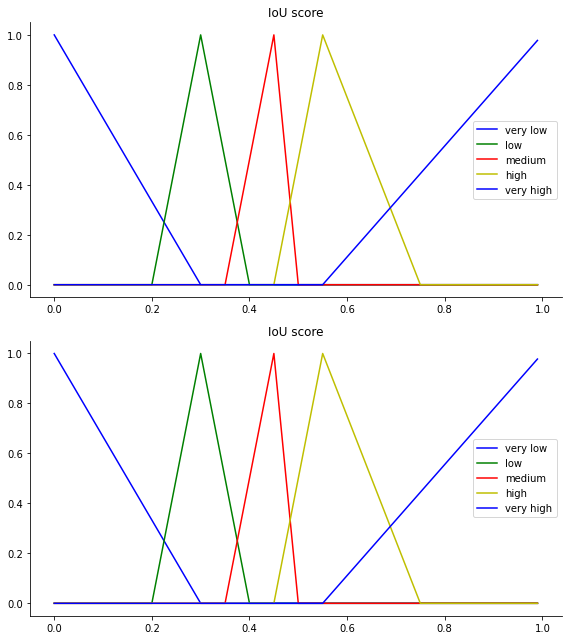

In [20]:



# Visualize these universes and membership functions
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(8, 9))

ax0.plot(iou, iou_vlo, 'b', linewidth=1.5, label='very low')
ax0.plot(iou, iou_lo, 'g', linewidth=1.5, label='low')
ax0.plot(iou, iou_md, 'r', linewidth=1.5, label='medium')
ax0.plot(iou, iou_hi, 'y', linewidth=1.5, label='high')
ax0.plot(iou, iou_vhi, 'b', linewidth=1.5, label='very high')
ax0.set_title('IoU score')
ax0.legend()

ax1.plot(FIoU, FIoU_vlo, 'b', linewidth=1.5, label='very low')
ax1.plot(FIoU, FIoU_lo, 'g', linewidth=1.5, label='low')
ax1.plot(FIoU, FIoU_md, 'r', linewidth=1.5, label='medium')
ax1.plot(FIoU, FIoU_hi, 'y', linewidth=1.5, label='high')
ax1.plot(FIoU, FIoU_vhi, 'b', linewidth=1.5, label='very high')
ax1.set_title('IoU score')
ax1.legend()



# Turn off top/right axes
for ax in (ax0,ax1):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

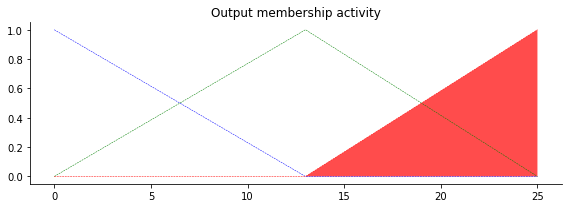

In [7]:
# We need the activation of our fuzzy membership functions at these values.
# The exact values 6.5 and 9.8 do not exist on our universes...
# This is what fuzz.interp_membership exists for!
qual_level_lo = fuzz.interp_membership(x_qual, qual_lo, 10.)
qual_level_md = fuzz.interp_membership(x_qual, qual_md, 10.)
qual_level_hi = fuzz.interp_membership(x_qual, qual_hi, 10.)

serv_level_lo = fuzz.interp_membership(x_serv, serv_lo, 10.)
serv_level_md = fuzz.interp_membership(x_serv, serv_md, 10.)
serv_level_hi = fuzz.interp_membership(x_serv, serv_hi, 10.)

# Now we take our rules and apply them. Rule 1 concerns bad food OR service.
# The OR operator means we take the maximum of these two.
active_rule1 = np.fmax(qual_level_lo, serv_level_lo)

# Now we apply this by clipping the top off the corresponding output
# membership function with `np.fmin`
tip_activation_lo = np.fmin(active_rule1, tip_lo)  # removed entirely to 0

# For rule 2 we connect acceptable service to medium tipping
tip_activation_md = np.fmin(serv_level_md, tip_md)

# For rule 3 we connect high service OR high food with high tipping
active_rule3 = np.fmax(qual_level_hi, serv_level_hi)
tip_activation_hi = np.fmin(active_rule3, tip_hi)
tip0 = np.zeros_like(x_tip)

# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.fill_between(x_tip, tip0, tip_activation_lo, facecolor='b', alpha=0.7)
ax0.plot(x_tip, tip_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.fill_between(x_tip, tip0, tip_activation_md, facecolor='g', alpha=0.7)
ax0.plot(x_tip, tip_md, 'g', linewidth=0.5, linestyle='--')
ax0.fill_between(x_tip, tip0, tip_activation_hi, facecolor='r', alpha=0.7)
ax0.plot(x_tip, tip_hi, 'r', linewidth=0.5, linestyle='--')
ax0.set_title('Output membership activity')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()

tip == 21.0


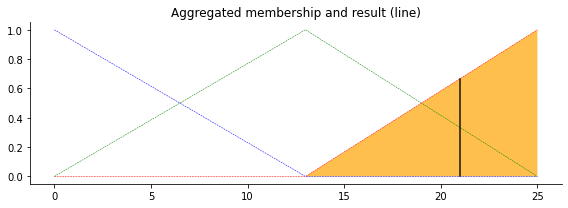

In [8]:
# Aggregate all three output membership functions together
aggregated = np.fmax(tip_activation_lo,
                     np.fmax(tip_activation_md, tip_activation_hi))

# Calculate defuzzified result
tip = fuzz.defuzz(x_tip, aggregated, 'centroid')
tip_activation = fuzz.interp_membership(x_tip, aggregated, tip)  # for plot

# Visualize this
fig, ax0 = plt.subplots(figsize=(8, 3))

ax0.plot(x_tip, tip_lo, 'b', linewidth=0.5, linestyle='--', )
ax0.plot(x_tip, tip_md, 'g', linewidth=0.5, linestyle='--')
ax0.plot(x_tip, tip_hi, 'r', linewidth=0.5, linestyle='--')
ax0.fill_between(x_tip, tip0, aggregated, facecolor='Orange', alpha=0.7)
ax0.plot([tip, tip], [0, tip_activation], 'k', linewidth=1.5, alpha=0.9)
ax0.set_title('Aggregated membership and result (line)')

# Turn off top/right axes
for ax in (ax0,):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.tight_layout()
print(f"tip == {tip}")